In [54]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
import networkx as nx
from tqdm import tqdm

# Neural Network, Torch
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.nn as nn
import torch.optim as optim
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Batch

In [56]:
# Importing the dataset from the pickle file
dataset = pd.read_csv('data_no_qm.csv')
unknown = np.zeros(len(dataset))

# It should only consider the target columns, which are 'storage', 'tbr', 'max_abs', 'osc_str', 'abs_prod', 'osc_prod', 'sce'
# We will also remove the 'rep' column, as it is not a target column
# 'smiles' column is the input

for i in tqdm(range(len(dataset))):
    if dataset['storage'].iloc[i] <= 0:
        unknown[i] = 1
    elif dataset['tbr'].iloc[i] <= 0:
        unknown[i] = 1
    elif dataset['max_abs'].iloc[i] <= 0:
        unknown[i] = 1
    elif dataset['osc_str'].iloc[i] <= 0:
        unknown[i] = 1
    elif dataset['abs_prod'].iloc[i] <= 0:
        unknown[i] = 1
    elif dataset['osc_prod'].iloc[i] <= 0:
        unknown[i] = 1
    elif dataset['sce'].iloc[i] <= 0:
        unknown[i] = 1
        

# Remove the rows with negative values from the original dataset
validation_dataset = dataset.loc[np.where(unknown == 1)[0]]
dataset = dataset.drop(np.where(unknown == 1)[0])

# Reset the index of the test dataset
test_dataset = validation_dataset.reset_index(drop=True)

# Reset the index of the dataset
dataset = dataset.reset_index(drop=True)

# We will now remove the 'rep' column from the dataset
dataset = dataset.drop(columns=['rep'])

# We will now remove the 'rep' column from the test dataset
validation_dataset = validation_dataset.drop(columns=['rep'])

100%|██████████| 466281/466281 [02:13<00:00, 3500.53it/s]


storage     0
tbr         0
max_abs     0
osc_str     0
abs_prod    0
osc_prod    0
sce         0
smiles      0
dtype: int64


In [59]:
# For now we will only use 1000 molecules for training
dataset = dataset.iloc[:1000]

In [60]:
def smiles_to_xyz(smiles):
    """Input: SMILES string
    Output: XYZ coordinates of the molecule as a list of lists (atom symbol, x, y, z)"""
    # Generate a molecule object from the SMILES string
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)  # Add hydrogens to the molecule

    # Generate 3D coordinates
    AllChem.EmbedMolecule(mol)
    AllChem.UFFOptimizeMolecule(mol)

    # Extract the XYZ coordinates
    conformer = mol.GetConformer()
    xyz = []
    for atom in mol.GetAtoms():
        pos = conformer.GetAtomPosition(atom.GetIdx())
        xyz.append([atom.GetSymbol(), pos.x, pos.y, pos.z])
    return xyz

def format_xyz(xyz):
    """Format the xyz file as a string. To be used for writing to a file. Easy to print"""
    formatted = f"{len(xyz)}\n\n"  # Number of atoms
    for atom in xyz:
        formatted += f"{atom[0]} {atom[1]:.4f} {atom[2]:.4f} {atom[3]:.4f}\n"
    return formatted

def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.UFFOptimizeMolecule(mol)

    G = nx.Graph()
    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(), element=atom.GetSymbol())

    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond_type=bond.GetBondType())
    return G

def inspect_graph(graph):
    print("Nodes and their attributes:")
    for node in graph.nodes(data=True):
        print(node)

    print("\nEdges and their attributes:")
    for edge in graph.edges(data=True):
        print(edge)

def visualize_graph(graph):
    pos = nx.spring_layout(graph)  # Position nodes using Fruchterman-Reingold force-directed algorithm
    labels = nx.get_node_attributes(graph, 'element')
    nx.draw_networkx(graph, pos, with_labels=True, labels=labels, node_size=500, node_color="skyblue", font_size=15, font_color="black", font_weight="bold")
    edge_labels = nx.get_edge_attributes(graph, 'bond_type')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_color="red")
    plt.show()

# smiles = 'CCO'  # Example SMILES string
# graph = smiles_to_graph(smiles)

# # Assuming `graph` is the graph object from the previous step
# inspect_graph(graph)
# visualize_graph(graph)


In [61]:
# Make a list of graphs for each molecule in the dataset
graphs = [smiles_to_graph(smiles) for smiles in tqdm(dataset['smiles'])]

# Find each unique element in the graphs
elements = set()
for graph in tqdm(graphs):
    elements.update(nx.get_node_attributes(graph, 'element').values())

# Print the unique elements
print(elements)

100%|██████████| 1000/1000 [00:00<00:00, 10994.39it/s]

{'O', 'F', 'H', 'Cl', 'N', 'C'}


  0%|          | 0/10 [00:00<?, ?it/s]

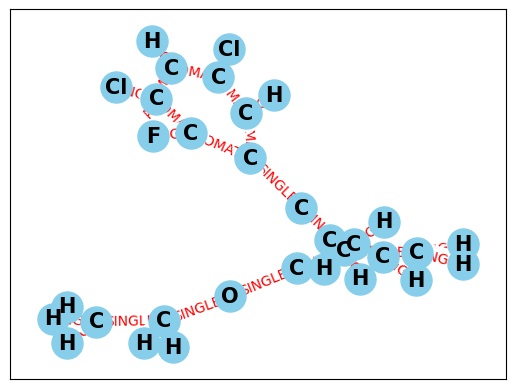

 10%|█         | 1/10 [00:01<00:12,  1.39s/it]

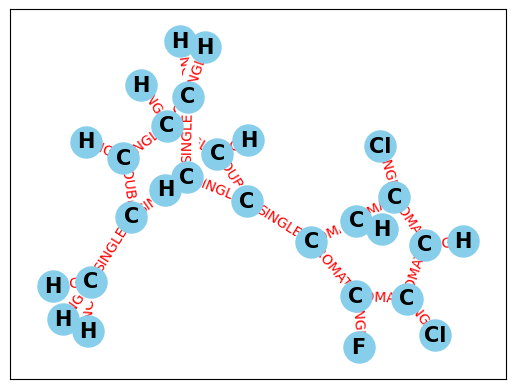

 20%|██        | 2/10 [00:02<00:10,  1.29s/it]

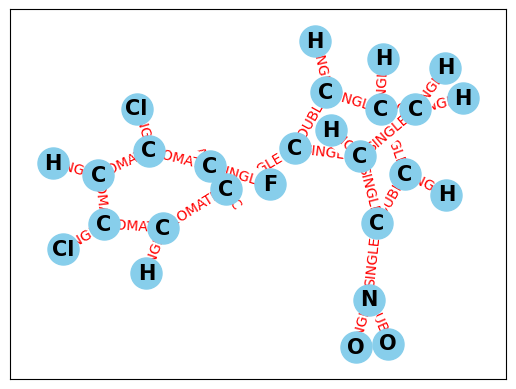

 30%|███       | 3/10 [00:03<00:08,  1.19s/it]

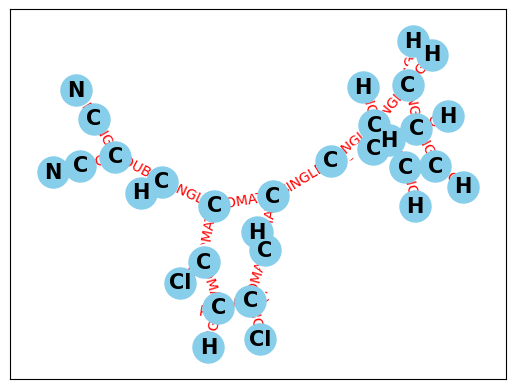

 40%|████      | 4/10 [00:04<00:07,  1.17s/it]

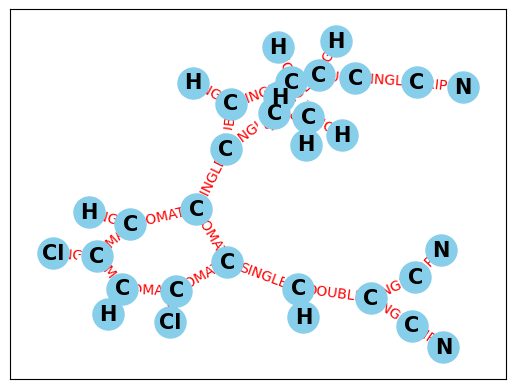

 50%|█████     | 5/10 [00:06<00:06,  1.28s/it]

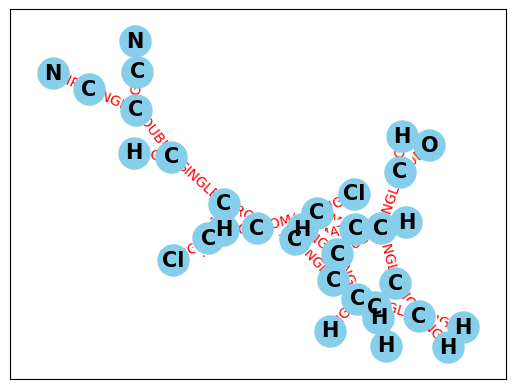

 60%|██████    | 6/10 [00:07<00:05,  1.41s/it]

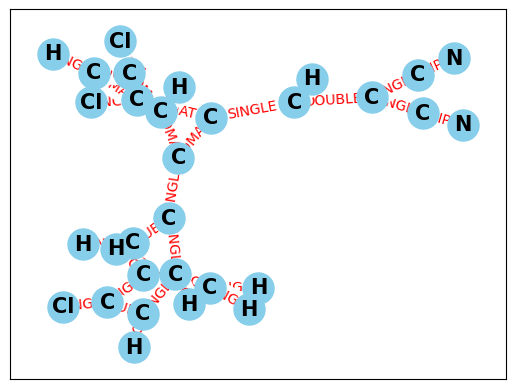

 70%|███████   | 7/10 [00:09<00:04,  1.50s/it]

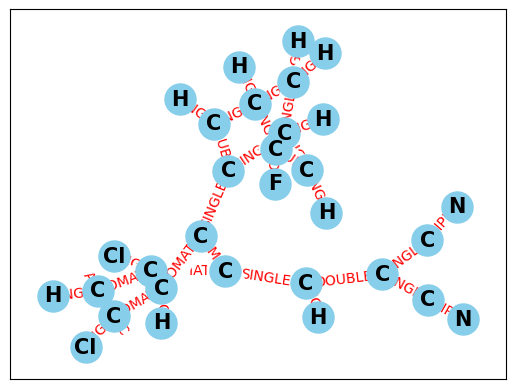

 80%|████████  | 8/10 [00:11<00:03,  1.55s/it]

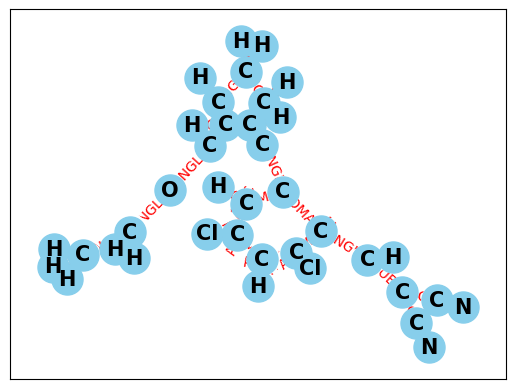

 90%|█████████ | 9/10 [00:12<00:01,  1.56s/it]

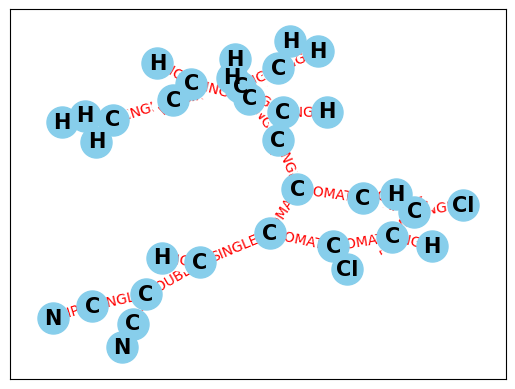

100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


In [41]:
# # Plot the graph of the first 10 molecules in the dataset
# for i in tqdm(range(10)):
#     smiles = dataset['smiles'][i]
#     graph = smiles_to_graph(smiles)
#     visualize_graph(graph)

In [48]:
# Let us try to make a basic Graph Convolutional Neural Network (GCN) model for the dataset


# Define a function for building the graph data object
def build_graph(smiles, target):
    graph = smiles_to_graph(smiles)
    node_features = []
    for node in graph.nodes(data=True):
        feature = torch.zeros(7)  # One-hot encoding for the atom type
        if node[1]['element'] == 'C':
            feature[0] = 1
        elif node[1]['element'] == 'O':
            feature[1] = 1
        elif node[1]['element'] == 'N':
            feature[2] = 1
        elif node[1]['element'] == 'F':
            feature[3] = 1
        elif node[1]['element'] == 'H':
            feature[4] = 1
        elif node[1]['element'] == 'Cl':
            feature[5] = 1
        else:
            feature[6] = 1
        node_features.append(feature)
    node_features = torch.stack(node_features)
    x = node_features.detach().clone()
    edge_index = torch.tensor(list(graph.edges), dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor([edge[2]['bond_type'] for edge in graph.edges(data=True)], dtype=torch.float).view(-1, 1)

    y = torch.tensor([target], dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

# Build the graph data object for the first molecule in the dataset
data = build_graph(dataset['smiles'][0], dataset['storage'][0])
print(data)

Data(x=[32, 7], edge_index=[2, 34], edge_attr=[34, 1], y=[1])


In [8]:
# Define a custom dataset class for the molecule dataset
class MoleculeDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.data = []
        for i in tqdm(range(len(dataset))):
            smiles = dataset['smiles'][i]
            # It should contain multiple targets as there are multiple properties: 'storage', 'tbr', 'max_abs', 'osc_str', 'abs_prod', 'osc_prod','sce'
            target = dataset[['storage', 'tbr', 'max_abs', 'osc_str', 'abs_prod', 'osc_prod', 'sce']].iloc[i].values
            self.data.append(build_graph(smiles, target))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def num_node_features(self):
        return 5
    
    @property
    def num_classes(self):
        return 7

# Make the dataset able to use .num_node_features, .num_classes, .train_mask, .test_mask, etc.
dataset = MoleculeDataset(dataset)


  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\45229\AppData\Local\Temp\ipykernel_17176\2712937205.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  y = torch.tensor([target], dtype=torch.float)
100%|██████████| 1000/1000 [01:57<00:00,  8.53it/s]


In [54]:
# Let us make a simple Graph Convolutional Neural Network (GCN) model

def build_GCN(num_node_features, num_classes, num_hidden_layers, size_hidden_layer1):
    conv_layers = []
    # Input layer
    conv_layers.append(GCNConv(num_node_features, size_hidden_layer1))
    # Hidden layers
    for i in range(num_hidden_layers):
        if i <= int(num_hidden_layers / 2):
            size_hidden_layer2 = int(size_hidden_layer1 * 1.2)
            conv_layers.append(GCNConv(size_hidden_layer1, size_hidden_layer2))
            conv_layers.append(nn.ReLU())
            size_hidden_layer1 = size_hidden_layer2
        else:
            size_hidden_layer2 = int(size_hidden_layer1 * 0.74)
            conv_layers.append(GCNConv(size_hidden_layer1, size_hidden_layer2))
            conv_layers.append(nn.ReLU())
            size_hidden_layer1 = size_hidden_layer2

    # Output layer
    conv_layers.append(GCNConv(size_hidden_layer1, num_classes))
    # Return The Graph Neural Network
    return nn.Sequential(*conv_layers)

# Define the loss function
def loss_fn(output, target):
    return F.mse_loss(output, target)

# Define a function for training the GCN
def train(model, data_loader, optimizer):
    model.train()
    total_loss = 0
    for data in data_loader:
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.edge_attr)
        loss = loss_fn(output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

# Define a function for evaluating the GCN
def evaluate(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in data_loader:
            output = model(data.x, data.edge_index, data.edge_attr)
            loss = loss_fn(output, data.y)
            total_loss += loss.item()
    return total_loss / len(data_loader)

In [55]:
# Let us split the graph data into training and test sets
from torch.utils.data import random_split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Define the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [57]:
# Define the model
model = build_GCN(dataset.num_node_features, dataset.num_classes, num_hidden_layers=3, size_hidden_layer1=64)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [58]:
# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer)
    test_loss = evaluate(model, test_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")



TypeError: Sequential.forward() takes 2 positional arguments but 4 were given